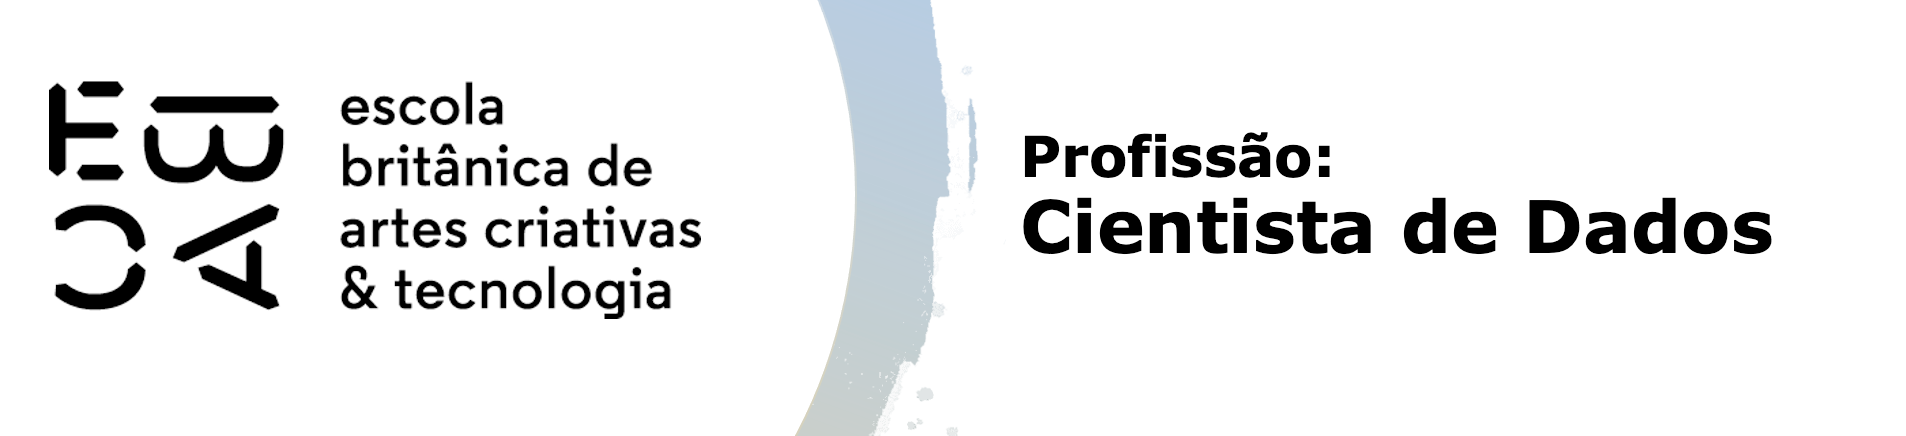

### Biblioteca

In [14]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, PowerTransformer, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

### Dados

In [15]:
def importar():
    dt = pd.read_feather('/content/drive/MyDrive/Ciência de Dados/credit_scoring.ftr')
    ID = dt.pop("index")
    dt['mes'] = dt['data_ref'].dt.month
    dt = dt.drop(axis=0, columns=['data_ref'])
    display(dt.head())
    return dt

In [ ]:
df = importar()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,mes
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,1
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,1
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,1
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,1
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,1


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
    Será utilizada a função SimpleImputer para o preenchimento dos dados faltantes. Para os dados do tipo numérico, será preenchido com a média, já para os dados categóricos será preenchido com a maior frequência.
</div>

In [ ]:
def funtion_1(dt):

    dados = dt.copy()
    categoric_ = []

    for col in dados.select_dtypes(exclude=np.number):
        categoric_.append(col)
        dados[col] = LabelEncoder().fit_transform(dados[col])

    # Separar colunas categoricas e numéricas
    numeric_ = list(set(dados.columns.tolist()) - set(categoric_))


    # Preencher vazio com pipeline dos numéricos
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    # Preencher vazio com pipeline dos categóricos.
    categorical_transformer = Pipeline(steps=[
        ('impute',SimpleImputer(strategy='most_frequent'))
    ])

    # Transformação
    processamento = ColumnTransformer(transformers=[
        ('num',numeric_transformer, numeric_),
        ('cat',categorical_transformer, categoric_)
    ])

    # Aplicando na função

    dados_transformados = processamento.fit_transform(dados)
    columns = numeric_ + categoric_
    processed_df = pd.DataFrame(dados_transformados, columns=columns)

    for i in categoric_:
        processed_df[i] = processed_df[i].astype(str)

    return processed_df


In [ ]:
df_tratado = funtion_1(df)
df_tratado.head()

,qt_pessoas_residencia,qtd_filhos,mes,idade,renda,tempo_emprego,sexo,posse_de_veiculo,posse_de_imovel,tipo_renda,educacao,estado_civil,tipo_residencia,mau
0,1.0,0.0,1.0,43.0,2515.39,6.873973,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0
1,2.0,0.0,1.0,35.0,3180.19,4.526027,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,4.0,2.0,1.0,31.0,1582.29,0.243836,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2.0,0.0,1.0,54.0,13721.17,12.772603,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,31.0,2891.08,8.432877,0.0,1.0,0.0,0.0,4.0,2.0,1.0,0.0


In [ ]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   qt_pessoas_residencia  750000 non-null  float64
 1   qtd_filhos             750000 non-null  float64
 2   mes                    750000 non-null  float64
 3   idade                  750000 non-null  float64
 4   renda                  750000 non-null  float64
 5   tempo_emprego          750000 non-null  float64
 6   sexo                   750000 non-null  object 
 7   posse_de_veiculo       750000 non-null  object 
 8   posse_de_imovel        750000 non-null  object 
 9   tipo_renda             750000 non-null  object 
 10  educacao               750000 non-null  object 
 11  estado_civil           750000 non-null  object 
 12  tipo_residencia        750000 non-null  object 
 13  mau                    750000 non-null  object 
dtypes: float64(6), object(8)
memory usag

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
    Será passada a função yeo-johnson como forma de tratamento dos dados numéricos com presença de outliers detectados na análise do exercício passado.
</div>

In [ ]:
def function_2(dt):
    dados = dt.copy()
    numeric_ = ['renda','tempo_emprego']

    numeric_transformer = Pipeline(steps=[
        ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=False))
    ])

    processamento = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_)
    ])

    dados_transformados = processamento.fit_transform(dados)
    for count, col in enumerate(numeric_):
        dados[col] = dados_transformados[:, count]


    return dados


In [ ]:
df_tratado = function_2(df_tratado)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
    Para o filtro das melhores features foi usado o SelectKBest.
</div>

In [ ]:
def function_3(dt):
    X = dt.copy()
    y = X.pop('mau')

    pipe = Pipeline(steps=[
        ('kbest', SelectKBest(score_func=f_classif, k=12))
    ])

    pipe.fit(X, y)

    selected_features = X.columns[pipe.named_steps['kbest'].get_support(indices=True)]

    selected_features_df = X[selected_features]
    selected_features_df['mau'] = y
    return selected_features_df

In [ ]:
df_tratado_skb = function_3(df_tratado)

In [ ]:
df_tratado_skb.head()

,qt_pessoas_residencia,qtd_filhos,mes,idade,renda,tempo_emprego,sexo,posse_de_imovel,tipo_renda,educacao,estado_civil,tipo_residencia,mau
0,1.0,0.0,1.0,43.0,5.374674,2.480548,0.0,0.0,2.0,1.0,2.0,1.0,0.0
1,2.0,0.0,1.0,35.0,5.478063,1.989518,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,4.0,2.0,1.0,31.0,5.162846,0.222376,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2.0,0.0,1.0,54.0,6.069350,3.319902,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,31.0,5.436343,2.742887,0.0,0.0,0.0,4.0,2.0,1.0,0.0


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [ ]:
def function_4(dt):
    dados = dt.copy()

    pipe = Pipeline(steps=[
        ('pca', PCA(n_components=5))
    ])


    return pd.DataFrame(pipe.fit_transform(dados))

In [ ]:
function_4(df_tratado)

,0,1,2,3,4
0,-0.700014,-4.612756,-1.163343,-1.563962,-0.630722
1,-8.826171,-4.611570,1.050727,-0.232962,-0.479050
2,-12.965719,-4.627058,1.308479,0.961324,-1.523941
3,10.170061,-4.584997,1.871916,0.071679,0.162659
4,-12.816456,-4.614423,-0.260333,-2.109338,2.419415
...,...,...,...,...,...
749995,4.176069,-2.618438,-0.494975,0.601248,0.995689
749996,21.300173,-2.620354,-1.093962,-0.947561,-0.530887
749997,-0.942568,-2.648879,1.888222,1.420766,-0.656262
749998,12.234876,-2.609411,0.760136,-3.475116,-0.034441


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [ ]:
def function_5(dt):
    X = dt.copy()
    y = X.pop('mau')

    # Identificar colunas para one-hot encoding
    onehot_cols = X.nunique()[X.nunique() < 12].index.tolist()
    dados_ = pd.get_dummies(X, columns=onehot_cols)
    dados_['mau'] = y


    return dados_


In [ ]:
function_5(df_tratado)

,mes,idade,renda,tempo_emprego,qt_pessoas_residencia_1.0,qt_pessoas_residencia_2.0,qt_pessoas_residencia_3.0,qt_pessoas_residencia_4.0,qt_pessoas_residencia_5.0,qt_pessoas_residencia_6.0,...,estado_civil_2.0,estado_civil_3.0,estado_civil_4.0,tipo_residencia_0.0,tipo_residencia_1.0,tipo_residencia_2.0,tipo_residencia_3.0,tipo_residencia_4.0,tipo_residencia_5.0,mau
0,1.0,43.0,5.374674,2.480548,True,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,0.0
1,1.0,35.0,5.478063,1.989518,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0.0
2,1.0,31.0,5.162846,0.222376,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,0.0
3,1.0,54.0,6.069350,3.319902,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0.0
4,1.0,31.0,5.436343,2.742887,True,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,3.0,48.0,5.295546,1.579051,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0.0
749996,3.0,65.0,5.101610,2.632516,True,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,0.0
749997,3.0,43.0,4.726358,3.023628,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,1.0
749998,3.0,56.0,5.599186,3.431863,True,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,1.0


### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [ ]:
def function_6(dt):
    dados = dt.copy()
    y = dados.pop('mau')
    categoric_ = []

    for col in dados.select_dtypes(exclude=np.number):
        categoric_.append(col)
        dados[col] = LabelEncoder().fit_transform(dados[col])

    # Separar colunas categoricas e numéricas
    numeric_ = list(set(dados.columns.tolist()) - set(categoric_))


    # Preencher vazio com pipeline dos numéricos
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=False))
    ])

    # Preencher vazio com pipeline dos categóricos.
    categorical_transformer = Pipeline(steps=[
        ('impute',SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore', drop='first'))
    ])

    # Transformação
    processamento = ColumnTransformer(transformers=[
        ('num',numeric_transformer, numeric_),
        ('cat',categorical_transformer, categoric_)
    ])

    # Aplicando na função

    dados_transformados = processamento.fit_transform(dados)
    columns = numeric_ + list(processamento.named_transformers_['cat']['onehot'].get_feature_names_out(categoric_))
    processed_df = pd.DataFrame(dados_transformados, columns=columns)

    pipe = Pipeline(steps=[
        ('pca', PCA(n_components=5))
    ])

    dados_ = pd.DataFrame(pipe.fit_transform(processed_df))
    dados_['mau'] = y
    return dados_


In [ ]:
dt_tratado = function_6(df)
dt_tratado.head()

,0,1,2,3,4,mau
0,0.051748,1.576722,-0.297796,-0.426227,-0.583479,False
1,0.946261,1.503846,-0.316261,-0.436159,0.176302,False
2,2.236260,1.732782,0.947677,-0.591568,-0.582067,False
3,-1.383493,1.458752,-0.681577,-0.377224,-0.237142,False
4,1.140988,1.329504,-1.244123,0.127791,-0.091444,False


# b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [ ]:
!pip install pycaret

In [8]:
from pycaret.classification import *

In [11]:
df = importar()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,mes
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,1
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,1
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,1
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,1
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,1


In [16]:
def balancear(dados):
    dt = dados.copy()
    rus = RandomUnderSampler(random_state=42)
    X_ = dt
    y_ = X_.pop('mau')

    X_resampled, y_resampled = rus.fit_resample(X_, y_)
    X_resampled['mau'] = y_resampled

    return X_resampled

In [17]:
df_balanceado = balancear(df)

In [18]:
clf = setup(
    df_balanceado,
    target='mau',
    normalize=True,
    normalize_method='zscore',
    transformation=True,
    transformation_method='yeo-johnson',
    remove_outliers=True,
    remove_multicollinearity=True, multicollinearity_threshold=0.95,

)

,Description,Value
0,Session id,8556
1,Target,mau
2,Target type,Binary
3,Original data shape,"(117286, 14)"
4,Transformed data shape,"(113182, 31)"
5,Transformed train set shape,"(77996, 31)"
6,Transformed test set shape,"(35186, 31)"
7,Ordinal features,3
8,Numeric features,6
9,Categorical features,7


In [19]:
modelo = create_model('lightgbm', fold=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7066,0.7812,0.7333,0.6961,0.7142,0.4132,0.4138
1,0.7183,0.7901,0.7223,0.7166,0.7194,0.4366,0.4366
2,0.6997,0.7727,0.7055,0.6974,0.7014,0.3993,0.3994
3,0.7046,0.7764,0.7344,0.6931,0.7131,0.4092,0.4099
4,0.7220,0.7873,0.7406,0.7140,0.7270,0.4439,0.4442
5,0.7150,0.7876,0.7270,0.7099,0.7183,0.4299,0.4301
6,0.7113,0.7829,0.7262,0.7051,0.7155,0.4226,0.4228
7,0.7018,0.7733,0.7248,0.6929,0.7085,0.4036,0.4041
8,0.7097,0.7805,0.7317,0.7007,0.7159,0.4193,0.4197


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
tuned_lg = tune_model(modelo, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7074,0.7844,0.7569,0.6888,0.7212,0.4149,0.4169
1,0.7012,0.7746,0.7442,0.6853,0.7135,0.4024,0.4039
2,0.6926,0.7709,0.7657,0.6680,0.7135,0.3851,0.3893
3,0.7197,0.7917,0.7764,0.6974,0.7348,0.4395,0.4423
4,0.7045,0.7754,0.7593,0.6843,0.7199,0.4090,0.4115
5,0.7112,0.7788,0.7654,0.6905,0.7261,0.4224,0.4249
6,0.7052,0.7772,0.7747,0.6802,0.7244,0.4105,0.4145
7,0.7086,0.7837,0.7698,0.6859,0.7254,0.4173,0.4205
8,0.7046,0.7809,0.7579,0.6849,0.7196,0.4093,0.4116


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [25]:
final_lg = finalize_model(tuned_lg)

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
    Devido o tamanho dos dados, o programa desativou o plot, sendo assim
</div>

In [26]:
save_model(final_lg, 'final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda',
                                              'mes'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('catego